In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.DataFrame.from_csv('./dnc-temporalGraph/out.dnc-temporalGraph', sep = '\t', header = 0, index_col=None)
data = data.drop('weight', 1)
data.head()

,from,to,timestamp
0,419,465,1463507482
1,869,453,1462337903
2,943,1151,1463167636
3,943,217,1463167636
4,943,841,1463167636


In [2]:
n = np.max(data['to'])
A = np.zeros((n,n))
for index, row in data.iterrows():
    A[row['from']-1, row['to']-1] = 1 #+=1

In [3]:
import networkx as nx
G = nx.from_numpy_matrix(A,create_using=nx.DiGraph())
G.is_directed()

True

Email Graph


C:\Users\hp\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\hp\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\hp\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\hp\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


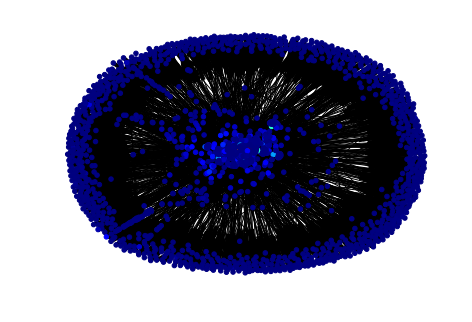

In [4]:
def draw(G):
    pos = nx.spring_layout(G)
    degree = G.degree()
    nodes = G.nodes()
    n_color = np.asarray([degree[n] for n in nodes])
    nx.draw(G, pos, node_color=n_color, node_size=20, cmap=plt.cm.jet)
    plt.show()
print('Email Graph')
draw(G)

# Laplacian matrix

From the laplacian matrix of the graph we can extract different properties.

- The multiplicity of the eigenvalue 0 is the number of connected components.

- The eigenvalue 2 is related to the time the system need to be synchronized. When it is zero there are at least two disconnected components and the system will never synchronize.

In [55]:
H_max = max(nx.connected_component_subgraphs(G.to_undirected()), key=len)
L = nx.laplacian_matrix(H_max)
L = L.toarray()
eigval, eigvect = np.linalg.eig(L)
eigval = np.sort(eigval)
eigval = eigval.tolist()
my_dict = {i:eigval.count(i) for i in eigval}
#print(my_dict)
print("Eigenvalue 0 has multiplicity: {}".format(my_dict[eigval[0]]))
print("Second smallest eigenvalue: {}".format(eigval[1]))

Eigenvalue 0 has multiplicity: 1
Second smallest eigenvalue: (0.04577572477824261+0j)


# Random Walk

In order to be able to compute random walk, we compute the probability matrix. There are two types of probabilities:
$$p_{i\leftarrow j} = \dfrac{1}{k_i}$$
$$p_{i\leftarrow j} = \dfrac{1}{k^{max}}$$

The first one is the most typical, but it produces accumulation in high degree nodes.

The second can be used to get more homogeneous result.

[[ 0.          0.          0.         ...,  0.          0.          0.01041667]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


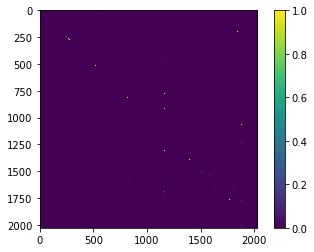

In [23]:
M = A
M_deg = M
for i in range(0,M_deg.shape[0]):
    if (np.sum(M_deg[i]) > 0):
        M_deg[i] = M_deg[i]/np.sum(M_deg[i])
print(M_deg)
plt.imshow(M_deg)
plt.colorbar()
plt.show()

464 580
1873
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   5.13642341e-06]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]


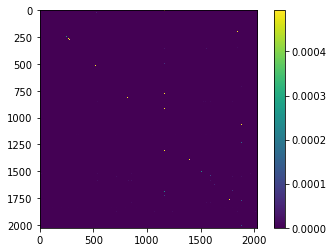

In [24]:
deg = nx.degree(G)
node_max_deg = max(deg, key=deg.get)
print(deg[1668], deg[1873])
print(node_max_deg)
max_deg = max(nx.degree(G))
M_max_deg = A/max_deg
print(M_max_deg)
plt.imshow(M_max_deg)
plt.colorbar()
plt.show()

We tried to simulate the random walk with pycx, but due to problems in compatibility, we couldn't, but here is the code for the simulation, which can be run in other environments.

In [ ]:
# %load net-randomwalk.py
# Simple Network Dynamics simulator in Python
#
# *** Random Walk on a Network ***
#
# Copyright 2010-2013 Hiroki Sayama
# sayama@binghamton.edu

import matplotlib
matplotlib.use('qt4agg')

import pylab as PL
import networkx as NX
import random as RD

n = 50
p = 0.1

def init():
    global g, positions, loc
    g = G
    for nd in g.nodes_iter():
        g.node[nd]['count'] = 0
    positions = NX.spring_layout(g)
    loc = 0

def draw():
    PL.cla()
    NX.draw(g, pos = positions, node_color = [g.node[nd]['count'] for nd in g.nodes_iter()], cmap = PL.cm.Blues, vmin = 0)
    NX.draw_networkx_nodes(g, pos = positions, node_color = 'r', nodelist = [loc])
    
def step():
    global loc
    g.node[loc]['count'] += 1
    if g.neighbors(loc) != []:
        loc = RD.choice(g.neighbors(loc))
    
import pycxsimulator
pycxsimulator.GUI().start(func=[init,draw,step])


# PAGE RANK


In [12]:
pr = nx.pagerank(G)
#print(pr)
print(max(pr, key=pr.get))
print(np.max(pr))

1668
{0: 0.0032018005652710724, 1: 0.0004020764879509365, 2: 0.00029049699407400763, 3: 0.00028410950071078105, 4: 0.0002043097730005504, 5: 0.00035157398437644217, 6: 0.00035157398437644217, 7: 0.0002043097730005504, 8: 0.00035157398437644217, 9: 0.0002972487778326512, 10: 0.00022288201033035957, 11: 0.0007858140649840096, 12: 0.00036372318582855484, 13: 0.0007382115993006932, 14: 0.0006334290519355512, 15: 0.00023269029165700087, 16: 0.0003239527944472769, 17: 0.0002043097730005504, 18: 0.00026601122073920526, 19: 0.0002043097730005504, 20: 0.0008982197568779538, 21: 0.00032677664754996236, 22: 0.0002972487778326512, 23: 0.0004886063761152789, 24: 0.0007445143029833197, 25: 0.00035157398437644217, 26: 0.00023269029165700087, 27: 0.0002972487778326512, 28: 0.0002043097730005504, 29: 0.00035157398437644217, 30: 0.000732719132790069, 31: 0.0002043097730005504, 32: 0.00039592277351741716, 33: 0.0012947310278439228, 34: 0.00036169428716254057, 35: 0.00031556034036923984, 36: 0.00027552098

# Kuramoto model

We also tried to simulate the kuramoto model with pycx, but couldn't manage it, here's the code for the simulation in other environments.

In [ ]:
import matplotlib
matplotlib.use('TkAgg')
from pylab import *

def initialize():
    global g, nextg
    g = G
    g.pos = nx.spring_layout(g)
    for i in g.nodes_iter():
        g.node[i]['theta'] = 2* pi * random()
        g.node[j]['omega'] = 1. + uniform(-0.05, 0.05)
    nextg = g.copy()

    def observe():
        global g, nextg
        cla()
        nx.draw(g, cmap=cm.hsv, vmin=-1, vmax=1, 
               node_color = [sin(g.node[i]['theta']) for i in g.node_iter()],
               pos = g.pos)
        
alpha = 1 #coupling strength
Dt = 0.01 #Delta t

def update():
    global g, nextg
    for i in g.nodes_iter():
        theta_i = g.node[i]['theta']
        nextg.node[i]['theta'] = theta_i + (g.node[i]['omega'] + alpha * (sum(sin(g.node[j]['theta'] - theta_i) for j in g.neighbors(i))/g.degree(i))) * Dt
    g, nextg = nextg, g
    
#import pycxsimulator

GUI().start(func=[initialize, observe, update])